# Load Packages

In [53]:
#For Dataframe Manipulation
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing & feature selection
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder



# Load Datasets

In [54]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Combine train and test data for consistent one-hot encoding
train_data['is_train'] = 1
test_data['is_train'] = 0
combined_data = pd.concat([train_data, test_data], sort=False)

# Visualize missing Data

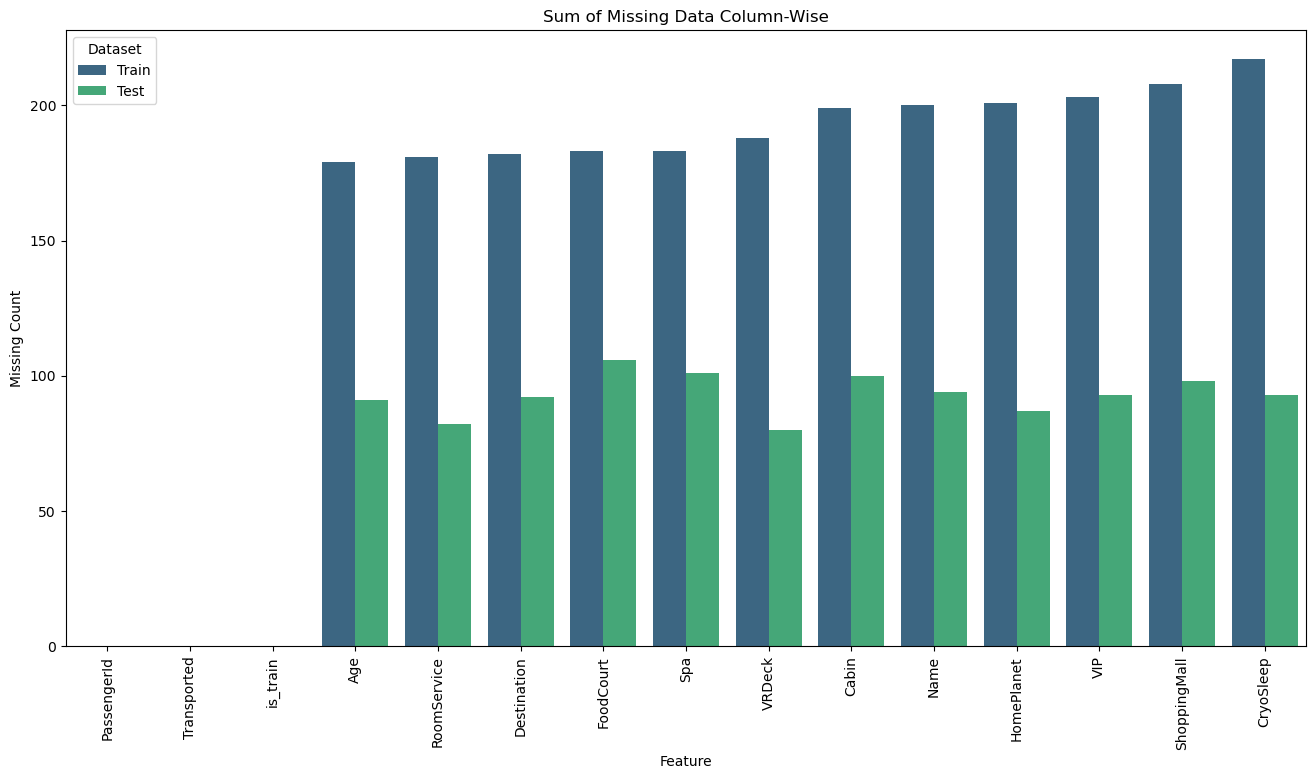

In [55]:
# Calculate the sum of missing data column-wise and row-wise
train_missing_column = train_data.isnull().sum().sort_values(ascending=True)
test_missing_column = test_data.isnull().sum().sort_values(ascending=True)
train_missing_row = train_data.isnull().sum(axis=1)
test_missing_row = test_data.isnull().sum(axis=1)

# Visualize sum of missing data column-wise
missing_cols = pd.concat([train_missing_column, test_missing_column], axis=1, keys=['Train', 'Test'])
missing_cols = missing_cols.reset_index().rename(columns={'index': 'Feature'})
missing_cols = pd.melt(missing_cols, id_vars=['Feature'], value_vars=['Train', 'Test'], var_name='Dataset', value_name='Missing Count')

plt.figure(figsize=(16,8))
sns.barplot(data=missing_cols, x='Feature', y='Missing Count', hue='Dataset', palette='viridis')
plt.xticks(rotation=90)
plt.title('Sum of Missing Data Column-Wise')
plt.show()

# Processing Training data

In [56]:
# Extracting numerical features
num_features = combined_data.select_dtypes(exclude = ['object', 'bool']).columns.tolist()
combined_data[num_features].head()

# Extracting categorical features
cat_features = combined_data.select_dtypes(include = ['object']).columns.tolist()
combined_data[cat_features].head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True


# Impute missing variables

In [57]:
# Impute missing values with Median for each Numerical feature
for col in num_features:
    combined_data[col] = combined_data[col].fillna(combined_data[col].median())

# Impute missing values with Mode for each Categorical feature
for col in cat_features:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mode()[0])


In [58]:
#combined_data.isnull().sum()
combined_data[cat_features].isnull().sum()

PassengerId    0
HomePlanet     0
CryoSleep      0
Cabin          0
Destination    0
VIP            0
Name           0
Transported    0
dtype: int64

# Encode categorical features

In [59]:

encoder = OrdinalEncoder()
combined_data[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']] = encoder.fit_transform(combined_data[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']])

# Split the data back into train and test sets

In [60]:
train_data = combined_data[combined_data['is_train'] == 1].drop(['is_train'], axis=1)
test_data = combined_data[combined_data['is_train'] == 0].drop(['is_train'], axis=1)

# Select features and target
features = train_data.drop(['PassengerId', 'Name', 'Transported'], axis=1).columns
target = ['Transported']

In [61]:
X = train_data[features]
y = train_data[target]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,208.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3241.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,1.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,1.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,3243.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


# Train logistic regression model

In [63]:

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train.values.ravel())

# Validate the model
y_pred = log_reg.predict(X_val)

# Print accuracy and other metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.7665324899367453
Confusion Matrix:
 [[637 224]
 [182 696]]
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.74      0.76       861
        True       0.76      0.79      0.77       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



# Predict Transported for test data

In [64]:

X_test = test_data[features]
y_test_pred = log_reg.predict(X_test)


# Create submission file

In [65]:

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Transported': y_test_pred})
submission.to_csv('LR_submission.csv', index=False)

print("Submission file created: sample_submission.csv")

Submission file created: sample_submission.csv
